<a href="https://colab.research.google.com/github/urazalinuraliev/California-Housing-Prices/blob/main/California_Housing_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Loading Dataset

In [2]:
housing = pd.read_csv("https://github.com/ageron/handson-ml2/blob/master/datasets/housing/housing.csv?raw=true")

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Information of data

In [4]:
housing.shape

(20640, 10)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

this gives us some general information on the dataset

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


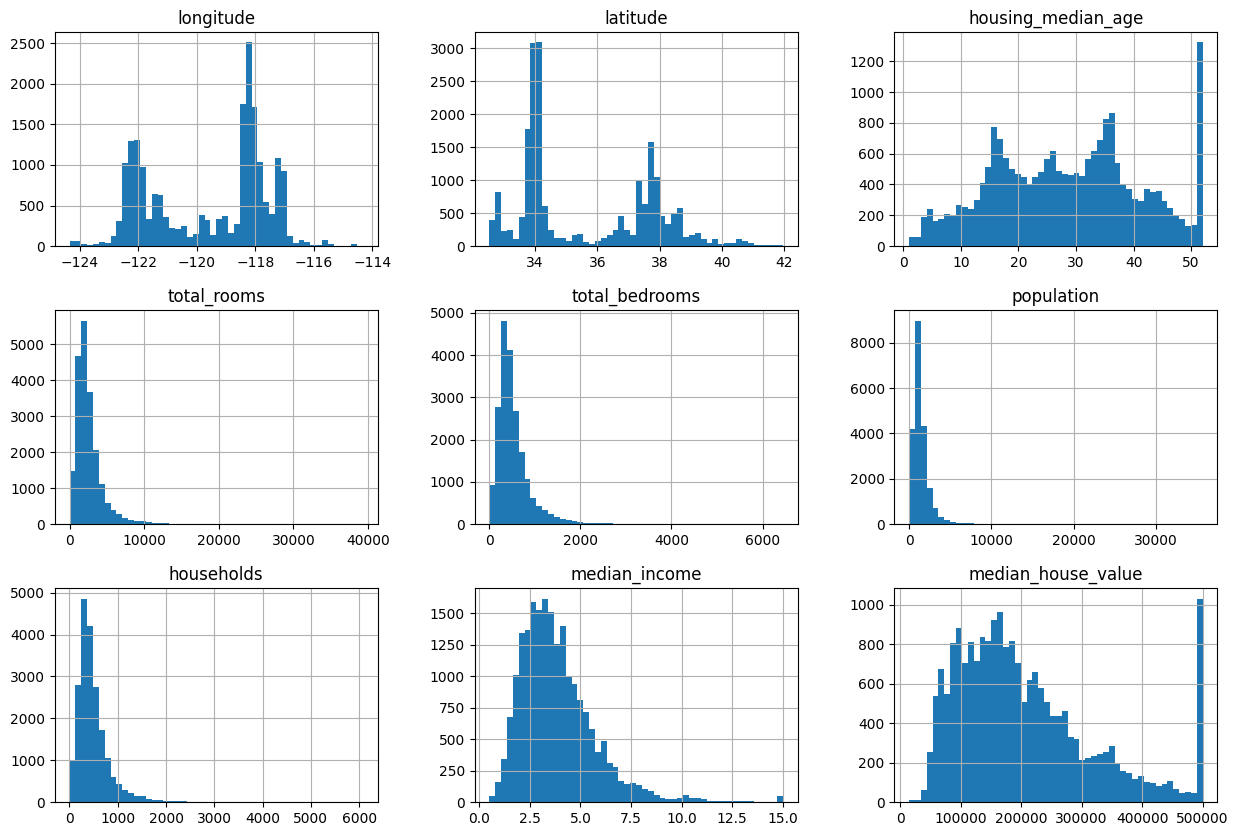

In [8]:
def print_histograms(data):
    data.hist(bins=50, figsize=(15, 10))

print_histograms(housing)

## Visualization of population and media house value

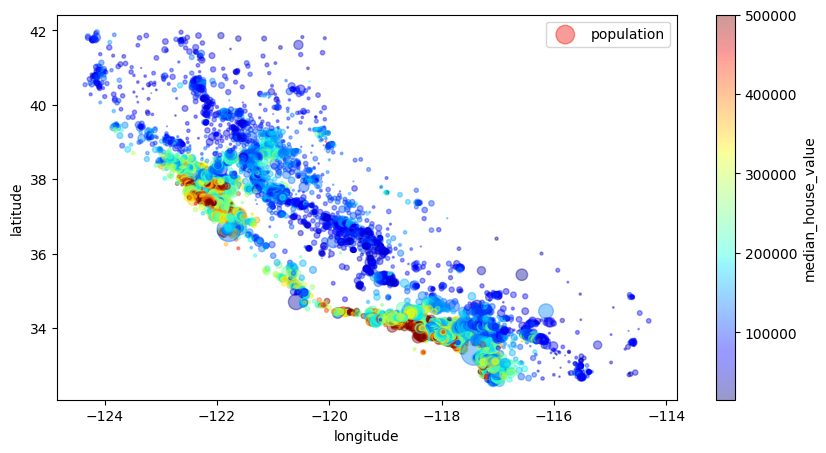

In [9]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4,
             s = housing["population"]/100, label = "population", figsize = (10,5),
             c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True
)

plt.show()

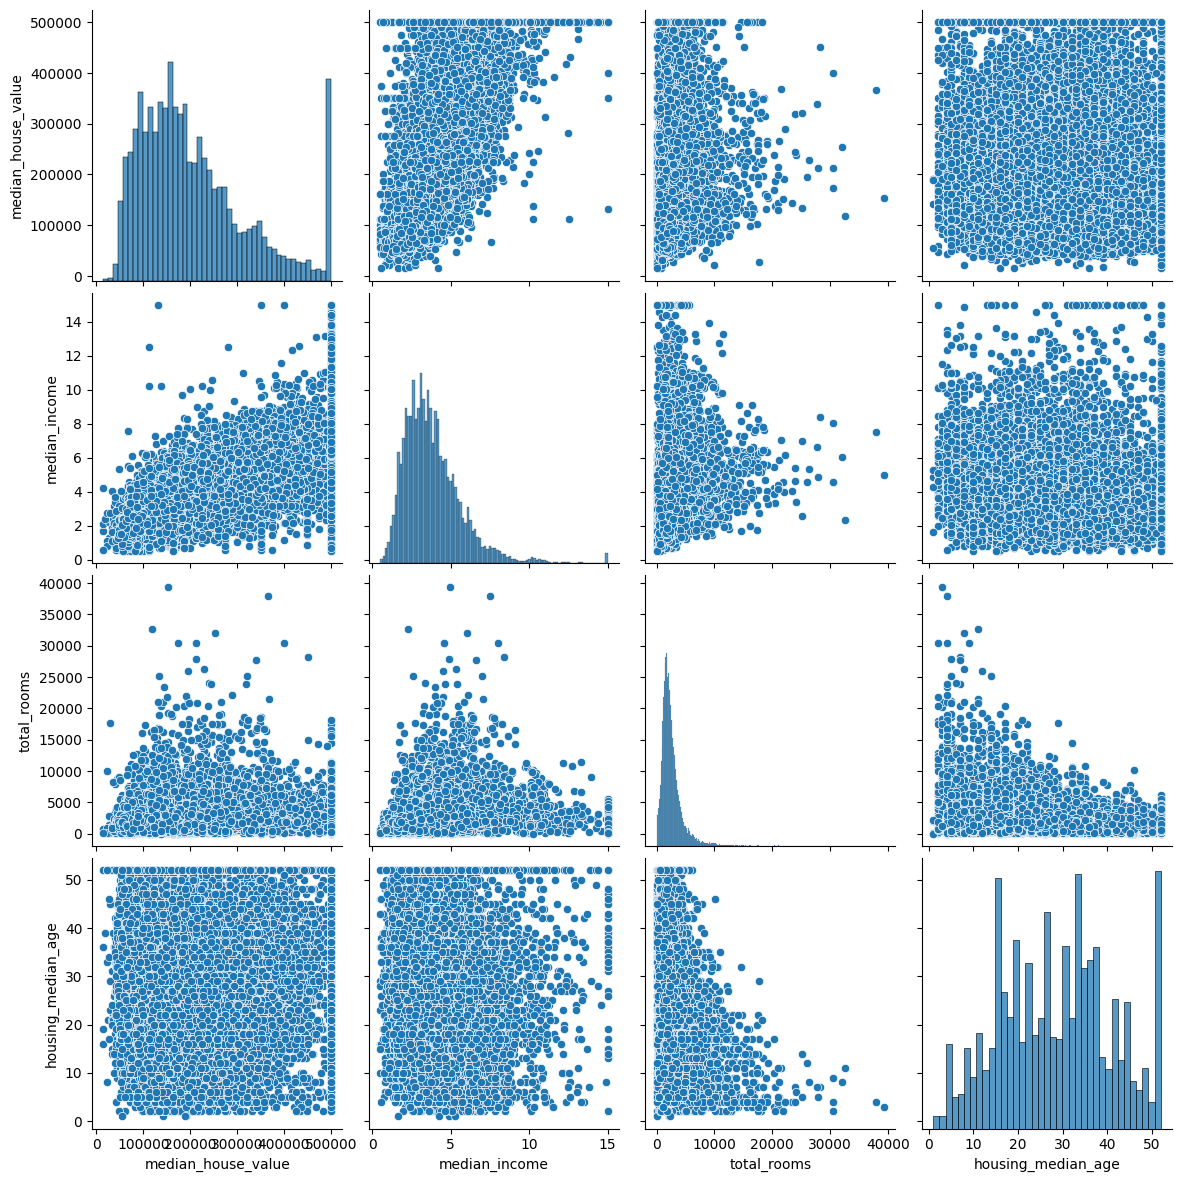

In [10]:
pair_plot = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
sns.pairplot(housing[pair_plot], height=3)
plt.show()

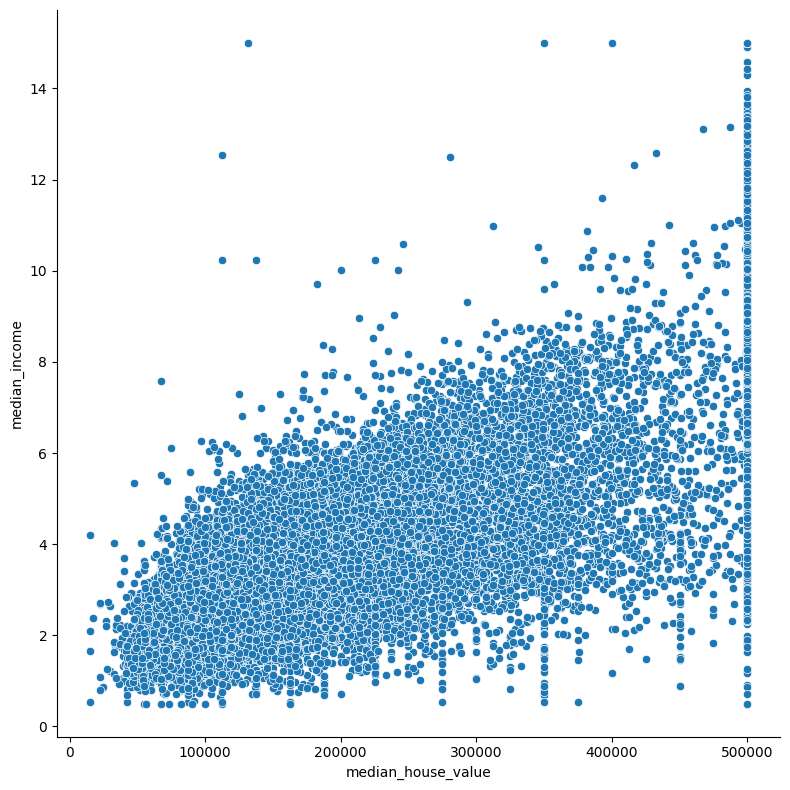

In [11]:
sns.relplot(x ="median_house_value", y ="median_income",
            data = housing, height=8);
plt.show()

In [12]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

X_train = train_set.drop("median_house_value", axis=1)
y = train_set["median_house_value"].copy()

X_num = X_train.drop("ocean_proximity", axis=1)

## Custom Transformers

Although Scikit-Learn provides us with many useful transformers, we will sometimes need to write our own, especially because we often need data-specific cleanup operations, or when we want to combine specific attributes into new attributes.

Since Scikit-Learn relies on duck typing, all we will have to do is create a class and write three methods:


* fit(), returning self
* transform()
* fit_transform() which we can get for free by simply adding TransformerMixin as a base class

In [13]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

## Transformation Pipelines

As there are many data transformation steps that need to be executed in a particular order, Scikit-Learn provides the Pipeline class to make these sequences of transformations easier and more convenient. If it was not for this, we would have to retype the execution (which also degrades code quality) or write our own function for that. This is a small pipeline for the numerical attributes:

In [14]:
num_pipeline = Pipeline([
          ('imputer', SimpleImputer(strategy='median')),
          ('attribs_adder', CombinedAttributesAdder(add_bedrooms_per_room = True)),
          ('std_scaler', StandardScaler())
])

* When we call the pipeline's fit() method, it calls fit_transform() sequentially on all transformers.

  passing the output of each call as the parameter to the next, until it reaches the final estimator. For the final estimator it then calls the fit() method.

 * The pipeline exposes same methods as the final estimator (in our example StandardScaler())

    * as that is a transformer, the pipeline has a transform() method that applies all transforms to the data in sequence (and of course also a      fit_transform, which we are using here).         

As we have handled the columns of numerical and categorical data seperately, it would be more convenient to have a single transformer to handle it all, applying the appropriate transformations to each column.

Fot this, Scikit-Learn provides the ColumnTransformer, which also works well for Pandas DataFrames, as used in this project.

This is an application of that on our housing data:

In [15]:
num_attribs = list(X_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])
X_prepared = full_pipeline.fit_transform(X_train)

Now we have a preprocessing pipeline that takes the full housing data and applies the appropriate transformation to each column.

## LinearRegression

In [16]:
LR_model = LinearRegression()
LR_model.fit(X_prepared, y)

LinearRegression()

In [17]:
test_data = X_train.sample(5)
test_labels = y.loc[test_data.index]

In [18]:
test_data_prepared = full_pipeline.transform(test_data)
test_data_prepared

array([[ 1.21773994, -1.36345054, -0.20697195, -1.00801253, -0.9701725 ,
        -0.97575338, -1.02632976,  0.0626213 , -0.54739381, -0.01629797,
         1.38765847,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.60445493, -0.72692539, -0.52437892,  0.73807106,  1.70528087,
         0.29862836,  1.75876566, -0.38285914, -0.75621771, -0.13711397,
         1.41694537,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.66927367, -0.70820406,  0.66589722, -0.45894121, -0.34247916,
        -0.41112048, -0.3070874 , -0.27158093, -0.47870213, -0.05121995,
         0.47263231,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.86643188,  1.17796971, -1.15919286, -0.27269843, -0.33531916,
        -0.31261754, -0.34383701, -0.19995116,  0.04926502, -0.01680045,
        -0.32101594,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.10306063, -0.78308938,  0

In [19]:
predicted_data = LR_model.predict(test_data_prepared)

In [20]:
pd.DataFrame({"Predictions:":predicted_data, "Labels:": test_labels})

,Predictions:,Labels:
14330,244096.004122,137500.0
8834,276213.112797,341700.0
5798,215273.155931,257700.0
16428,125635.557573,240800.0
11888,85171.671037,92400.0


In [21]:
X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value'].copy()

In [22]:
X_test_prepared = full_pipeline.transform(X_test)

In [23]:
y_predicted = LR_model.predict(X_test_prepared)

We use root mean square error (RMSE) to compare forecast and actual data.

In [24]:
lin_mse = mean_squared_error(y_test, y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

72701.32600762138


So RMSE = 72701 dollars came out. Not bad, but good either. That means our model is wrong by an average of 72,000 dollar when it comes to evaluating homes

## DecisionTree

In [25]:
Tree_model = DecisionTreeRegressor()
Tree_model.fit(X_prepared, y)

DecisionTreeRegressor()

In [26]:
y_predicted = Tree_model.predict(X_test_prepared)

In [27]:
lin_mse = mean_squared_error(y_test, y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

71970.14182416824


It wasn't much different than before.

## RandomForest

In [28]:
RF_model = RandomForestRegressor()
RF_model.fit(X_prepared, y)

RandomForestRegressor()

In [29]:
y_predicted = RF_model.predict(X_test_prepared)
lin_mse = mean_squared_error(y_test, y_predicted)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

50436.98530831544


It gave better results than before